## Trajectory discretization; converting trajectories to roadID list
<B>Objective:</B> From the trajectory outputs of traj_2024_11, break a trajectory into a sequence of road IDs traversed (Another approach to rout_2024_11)

<H3>rout_2025_05_01: Data Loading and Preprocessing </H3>
Load the trajectory data from traj_2024_11

In [15]:
# Install required libraries
############################

import requests
import json
import time
import datetime
from urllib.request import urlopen
import requests
import warnings
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns
import osmnx as ox
import networkx as nx
import geopandas as gpd

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pyproj import CRS
import os
import movingpandas as mpd
from shapely.geometry import Point

# Suppress deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
# Read the trajectories dataframe
#################################

import pandas as pd
import geopandas as gpd
from shapely import wkt

# Date constants
dat = '02Aug' 
dated = '2023-08-02'

# Read and display the trajectory csv
kelowna_gps_01Aug_traj = pd.read_csv(f'traj/wkelowna_gps_{dat}_matched_trips_gdf.csv') # W Kelowna

'''
# 28 Sep
kelowna_gps_01Aug_traj = pd.read_csv(
    f'/media/tim/data/outputs/traj_2024_11/EKelowna/ekelowna_gps_{dat}_matched_trips_gdf.csv',
    on_bad_lines='skip',
    engine='python' # This is the crucial part
)'''
kelowna_gps_01Aug_traj.head()


,Unnamed: 0,day,gps_id,trip_id,geometry,time_pos_dict
0,0,2023-08-02,0022c192-3117-3b6d-bc6a-47324af16ae4,2,"LINESTRING (-119.6499044 49.8359008, -119.6502...",{Timestamp('2023-08-02 16:55:03'): <POINT (-11...
1,1,2023-08-02,0022c192-3117-3b6d-bc6a-47324af16ae4,4,LINESTRING (-119.5525279296668 49.871016539317...,{Timestamp('2023-08-02 22:48:12'): <POINT (-11...
2,2,2023-08-02,005a1d04-c1c0-3ec6-a0e3-ced44621ffb4,9,"LINESTRING (-119.6292979 49.8260618, -119.6287...",{Timestamp('2023-08-02 19:39:19'): <POINT (-11...
3,3,2023-08-02,007f408f-80fa-34b5-bdb1-4e7e2840e839,18,LINESTRING (-119.65332720044583 49.82905902002...,{Timestamp('2023-08-02 16:04:39'): <POINT (-11...
4,4,2023-08-02,00a34bf9-2113-3399-881d-6e7df2b8a1b0,25,LINESTRING (-119.60163544137528 49.83437538081...,{Timestamp('2023-08-02 23:48:01'): <POINT (-11...


In [17]:
# Convert to geodataframe
#########################

# Only apply wkt.loads to strings
kelowna_gps_01Aug_traj['geometry'] = kelowna_gps_01Aug_traj['geometry'].apply(
    lambda x: wkt.loads(x) if isinstance(x, str) else x
)

# Convert to GeoDataFrame
kelowna_gps_01Aug_traj = gpd.GeoDataFrame(kelowna_gps_01Aug_traj, geometry='geometry', crs='EPSG:4326')  # assuming it's in WGS84
### kelowna_gps_01Aug_traj = kelowna_gps_01Aug_traj.to_crs(epsg=26911)  # UTM zone 11N (Kelowna)
kelowna_gps_01Aug_traj


,Unnamed: 0,day,gps_id,trip_id,geometry,time_pos_dict
0,0,2023-08-02,0022c192-3117-3b6d-bc6a-47324af16ae4,2,"LINESTRING (-119.64990 49.83590, -119.65023 49...",{Timestamp('2023-08-02 16:55:03'): <POINT (-11...
1,1,2023-08-02,0022c192-3117-3b6d-bc6a-47324af16ae4,4,"LINESTRING (-119.55253 49.87102, -119.55198 49...",{Timestamp('2023-08-02 22:48:12'): <POINT (-11...
2,2,2023-08-02,005a1d04-c1c0-3ec6-a0e3-ced44621ffb4,9,"LINESTRING (-119.62930 49.82606, -119.62875 49...",{Timestamp('2023-08-02 19:39:19'): <POINT (-11...
3,3,2023-08-02,007f408f-80fa-34b5-bdb1-4e7e2840e839,18,"LINESTRING (-119.65333 49.82906, -119.65331 49...",{Timestamp('2023-08-02 16:04:39'): <POINT (-11...
4,4,2023-08-02,00a34bf9-2113-3399-881d-6e7df2b8a1b0,25,"LINESTRING (-119.60164 49.83438, -119.60192 49...",{Timestamp('2023-08-02 23:48:01'): <POINT (-11...
...,...,...,...,...,...,...
2856,2856,2023-08-02,ff91cb39-09e7-3056-8f6e-30aae3c8227e,8553,"LINESTRING (-119.61797 49.83084, -119.61763 49...",{Timestamp('2023-08-02 14:26:00'): <POINT (-11...
2857,2857,2023-08-02,ff91cb39-09e7-3056-8f6e-30aae3c8227e,8556,"LINESTRING (-119.62960 49.82958, -119.63028 49...",{Timestamp('2023-08-02 23:29:17'): <POINT (-11...
2858,2858,2023-08-02,ffa2caf8-439f-376c-b6ef-132a9353b88b,8557,"LINESTRING (-119.65539 49.83118, -119.65514 49...",{Timestamp('2023-08-02 06:25:06'): <POINT (-11...
2859,2859,2023-08-02,ffd42394-0011-33f9-ab8f-bef741a681d6,8561,"LINESTRING (-119.53471 49.88669, -119.53445 49...",{Timestamp('2023-08-02 20:53:05'): <POINT (-11...


In [18]:
# Read the GPS (along with trip_id) dataframe
#############################################
'''
import folium
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point

# Read and display the trajectory csv
kelowna_gps_with_trip_id_0 = pd.read_csv(f'/media/tim/data/outputs/traj_2024_11/EKelowna/ekelowna_gps_{dat}_with_trip_id.csv') # E Kelowna
kelowna_gps_with_trip_id_0['DateTime'] = pd.to_datetime(kelowna_gps_with_trip_id_0['DateTime'])
kelowna_gps_with_trip_id_0.head()
'''

"\nimport folium\nimport pandas as pd\nimport geopandas as gpd\nfrom shapely import wkt\nfrom shapely.geometry import Point\n\n# Read and display the trajectory csv\nkelowna_gps_with_trip_id_0 = pd.read_csv(f'/media/tim/data/outputs/traj_2024_11/EKelowna/ekelowna_gps_{dat}_with_trip_id.csv') # E Kelowna\nkelowna_gps_with_trip_id_0['DateTime'] = pd.to_datetime(kelowna_gps_with_trip_id_0['DateTime'])\nkelowna_gps_with_trip_id_0.head()\n"

In [19]:
# Convert to geodataframe
#########################
'''
# Create a geometry column from latitude and longitude and create gdf for Halifax
geometry = [Point(xy) for xy in zip(kelowna_gps_with_trip_id_0['longitude'], kelowna_gps_with_trip_id_0['latitude'])]

# Convert to GeoDataFrame
kelowna_gps_with_trip_id_0 = gpd.GeoDataFrame(kelowna_gps_with_trip_id_0, geometry=geometry, crs='EPSG:4326')  # assuming it's in WGS84
kelowna_gps_with_trip_id_0
'''

"\n# Create a geometry column from latitude and longitude and create gdf for Halifax\ngeometry = [Point(xy) for xy in zip(kelowna_gps_with_trip_id_0['longitude'], kelowna_gps_with_trip_id_0['latitude'])]\n\n# Convert to GeoDataFrame\nkelowna_gps_with_trip_id_0 = gpd.GeoDataFrame(kelowna_gps_with_trip_id_0, geometry=geometry, crs='EPSG:4326')  # assuming it's in WGS84\nkelowna_gps_with_trip_id_0\n"

In [20]:
# Due to GPS data collection errors, remove erroneous GPS entries from outside the city e.g. forests, mountains
###############################################################################################################
'''
import geopandas as gpd
from shapely.geometry import shape

error_zone_1 = {"type":"Polygon","coordinates":[[[-119.7862466056271,49.84895618587456],[-119.70884058072033,49.84765412193666],
                                                 [-119.7074943889826,49.9020938426339],[-119.78355422215206,49.90274414545878],
                                                 [-119.7862466056271,49.84895618587456]]]}

# Step 1: Convert your error zone dictionary to a Shapely Polygon
error_polygon = shape(error_zone_1)

# Step 3: Filter out points that fall inside the error polygon
kelowna_gps_with_trip_id = kelowna_gps_with_trip_id_0[~kelowna_gps_with_trip_id_0.geometry.within(error_polygon)]
kelowna_gps_with_trip_id
'''

'\nimport geopandas as gpd\nfrom shapely.geometry import shape\n\nerror_zone_1 = {"type":"Polygon","coordinates":[[[-119.7862466056271,49.84895618587456],[-119.70884058072033,49.84765412193666],\n                                                 [-119.7074943889826,49.9020938426339],[-119.78355422215206,49.90274414545878],\n                                                 [-119.7862466056271,49.84895618587456]]]}\n\n# Step 1: Convert your error zone dictionary to a Shapely Polygon\nerror_polygon = shape(error_zone_1)\n\n# Step 3: Filter out points that fall inside the error polygon\nkelowna_gps_with_trip_id = kelowna_gps_with_trip_id_0[~kelowna_gps_with_trip_id_0.geometry.within(error_polygon)]\nkelowna_gps_with_trip_id\n'

<H3>rout_2025_05_02: Importing Road IDs</H3>
Import the road IDs from Kelowna shapefiles, combine them and display on a map

In [21]:
# Import road network for Kelowna city
######################################
'''
Source: https://www.arcgis.com/home/item.html?id=c3397c60106e40ad99cc69b40eece82b
'''
import geopandas as gpd
import contextily as ctx
'''
# Read file
ek_georoads_shp = gpd.read_file('/media/tim/data/wkelowna/ekelowna/ekelowna.shp')

 # Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)
ek_georoads_shp.to_crs(epsg=4326, inplace=True)

# Plot the geometries on a basemap
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the roads (your data)
ek_georoads_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)
   
# Use OpenStreetMap for the basemap
ctx.add_basemap(ax, crs=ek_georoads_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    
# Show the plot
plt.show()
'''

"\n# Read file\nek_georoads_shp = gpd.read_file('/media/tim/data/wkelowna/ekelowna/ekelowna.shp')\n\n # Set the Coordinate Reference System (CRS) if not already set (WGS84 - EPSG:4326 for lat/long)\nek_georoads_shp.to_crs(epsg=4326, inplace=True)\n\n# Plot the geometries on a basemap\nfig, ax = plt.subplots(figsize=(8, 8))\n\n# Plot the roads (your data)\nek_georoads_shp.plot(ax=ax, color='blue', linewidth=1, alpha=0.3)\n   \n# Use OpenStreetMap for the basemap\nctx.add_basemap(ax, crs=ek_georoads_shp.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)\n    \n# Show the plot\nplt.show()\n"

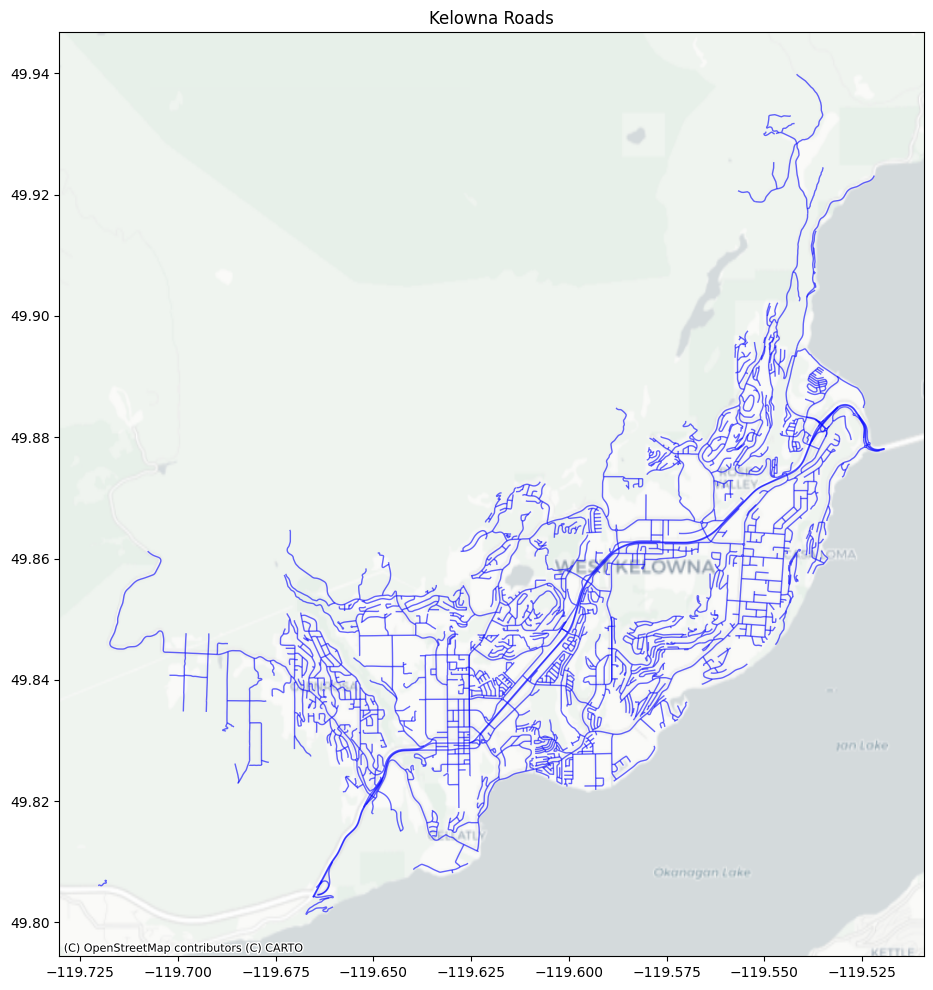

,ID,NAME,FULLNAME,TYPE,STREETTYPE,L_F_Add,R_F_Add,L_T_Add,R_T_Add,Kelowna,SHAPElen,geometry
0,1,Road_1,Road_1,NaN,30,NaN,NaN,NaN,NaN,W,39.172385,"LINESTRING (-119.61665 49.83770, -119.61627 49..."
1,2,Road_2,Road_2,NaN,30,NaN,NaN,NaN,NaN,W,68.910445,"LINESTRING (-119.61574 49.83927, -119.61508 49..."
2,3,Road_3,Road_3,NaN,30,NaN,NaN,NaN,NaN,W,81.479815,"LINESTRING (-119.61783 49.83903, -119.61705 49..."
3,4,Road_4,Road_4,NaN,30,NaN,NaN,NaN,NaN,W,35.918523,"LINESTRING (-119.61652 49.83782, -119.61662 49..."
4,5,Road_5,Road_5,NaN,30,NaN,NaN,NaN,NaN,W,124.894679,"LINESTRING (-119.61777 49.83819, -119.61734 49..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1726,1727,Road_None,Road_None,NaN,50,0.0,0.0,0.0,0.0,W,486.360357,"LINESTRING (-119.64601 49.85895, -119.64604 49..."
1727,1728,Bear Creek,Bear Creek Ln,Ln,10,985.0,986.0,1145.0,1146.0,W,580.627837,"LINESTRING (-119.54264 49.90721, -119.54239 49..."
1728,1729,Sunstone,Sunstone St,St,10,4011.0,4012.0,4111.0,4112.0,W,476.975973,"LINESTRING (-119.64541 49.81863, -119.64517 49..."
1729,1730,Sand Glass,Sand Glass Crt,Crt,10,4027.0,4026.0,4103.0,4104.0,W,386.099757,"LINESTRING (-119.64300 49.81831, -119.64300 49..."


In [22]:
# Import road network for West Kelowna
######################################

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import folium
import matplotlib.pyplot as plt
import contextily as ctx

# Read the CSV file
full_kelowna_roads = pd.read_csv('bc_gis/full_kelowna_roads.csv')
full_kelowna_roads = full_kelowna_roads.drop(columns=['Unnamed: 0'])

# Convert to GeoDataFrame - Method depends on your data structure

# Method 1: If your CSV has geometry column in WKT format
if 'geometry' in full_kelowna_roads.columns:
    # Convert WKT geometry string to shapely geometry
    full_kelowna_roads_gdf = gpd.GeoDataFrame(
        full_kelowna_roads, 
        geometry=gpd.GeoSeries.from_wkt(full_kelowna_roads['geometry']),
        crs='EPSG:4326'
    )

# Method 2: If your CSV has coordinate columns
elif all(col in full_kelowna_roads.columns for col in ['longitude', 'latitude']):
    # If points data
    full_kelowna_roads_gdf = gpd.GeoDataFrame(
        full_kelowna_roads,
        geometry=[Point(xy) for xy in zip(full_kelowna_roads['longitude'], full_kelowna_roads['latitude'])],
        crs='EPSG:4326'
    )

# Method 3: If you have start/end coordinates for road segments
elif all(col in full_kelowna_roads.columns for col in ['start_lon', 'start_lat', 'end_lon', 'end_lat']):
    # Create LineString geometries from start/end points
    full_kelowna_roads_gdf = gpd.GeoDataFrame(
        full_kelowna_roads,
        geometry=[
            LineString([
                (row['start_lon'], row['start_lat']),
                (row['end_lon'], row['end_lat'])
            ]) for idx, row in full_kelowna_roads.iterrows()
        ],
        crs='EPSG:4326'
    )

# Method 4: If you have multiple coordinate pairs (for complex road geometries)
elif 'coordinates' in full_kelowna_roads.columns:
    # Assuming coordinates column contains list of [lon, lat] pairs
    def create_geometry(coord_str):
        try:
            # Parse coordinate string and create appropriate geometry
            coords = eval(coord_str)  # Be careful with eval - use json.loads if it's JSON
            if len(coords) == 1:
                return Point(coords[0])
            else:
                return LineString(coords)
        except:
            return None
    
    full_kelowna_roads_gdf = gpd.GeoDataFrame(
        full_kelowna_roads,
        geometry=full_kelowna_roads['coordinates'].apply(create_geometry),
        crs='EPSG:4326'
    )

# Set CRS
full_kelowna_roads_gdf.to_crs(epsg=4326, inplace=True)

full_kelowna_roads_gdf = full_kelowna_roads_gdf[full_kelowna_roads_gdf['Kelowna']=='W']

# Create Folium map
def create_folium_map_from_gdf(gdf):
    """
    Create Folium map from GeoDataFrame
    """
    # Calculate bounds for centering
    bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles='CartoDB positron'  # More permissive tiles
    )
    
    # Add geometries to map based on geometry type
    for idx, row in gdf.iterrows():
        geometry = row['geometry']
        
        # Create popup with attribute information
        popup_content = "<div style='width: 300px;'><b>Road Information:</b><br>"
        for col, value in row.items():
            if col != 'geometry' and pd.notna(value):
                popup_content += f"<b>{col}:</b> {value}<br>"
        popup_content += "</div>"
        
        if geometry.geom_type == 'LineString':
            # Add road segment
            coordinates = [(point[1], point[0]) for point in list(geometry.coords)]
            folium.PolyLine(
                locations=coordinates,
                color='blue',
                weight=2,
                opacity=0.7,
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(m)
            
        elif geometry.geom_type == 'Point':
            # Add point
            folium.CircleMarker(
                location=[geometry.y, geometry.x],
                radius=4,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.8,
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(m)
            
        elif geometry.geom_type == 'MultiLineString':
            # Handle MultiLineString geometries
            for line in geometry.geoms:
                coordinates = [(point[1], point[0]) for point in list(line.coords)]
                folium.PolyLine(
                    locations=coordinates,
                    color='blue',
                    weight=2,
                    opacity=0.7,
                    popup=folium.Popup(f"Road segment {idx}", max_width=300)
                ).add_to(m)
    
    return m

# Create and display the Folium map
folium_map = create_folium_map_from_gdf(full_kelowna_roads_gdf)

# Display the map (if running in Jupyter)
folium_map

# Optional: Also show with matplotlib (your original approach)
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the roads
full_kelowna_roads_gdf.plot(ax=ax, color='blue', linewidth=1, alpha=0.6)

# Add basemap
try:
    ctx.add_basemap(ax, crs=full_kelowna_roads_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
except:
    # Fallback if contextily fails
    ctx.add_basemap(ax, crs=full_kelowna_roads_gdf.crs.to_string())

plt.title('Kelowna Roads')
plt.show()

# Print some information about the data
display(full_kelowna_roads_gdf)


<H3>rout_2025_05_03: Mapping trajectory to road ID</H3>
Converting trajectory to list of road IDs in sequential order

In [ ]:
# Function to determine the roadIDs intersected by the trajectory linestrings
#############################################################################

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')

def find_road_intersections_optimized(trajectory_geom, roads_gdf, max_distance=50):
    """
    Find road IDs that intersect or are near a trajectory, optimized version
    
    Parameters:
    trajectory_geom: LineString geometry of the trajectory
    roads_gdf: GeoDataFrame containing road geometries with ID column
    max_distance: maximum distance (in meters) to consider a road as intersecting
    
    Returns:
    list: ordered list of road IDs
    """
    # Convert to meters CRS for distance calculations if needed
    # Check if CRS is in degrees (assuming WGS84)
    if roads_gdf.crs.to_string().find('4326') != -1:
        # Transform to meters-based CRS for accurate distance calculations
        # UTM zone for Kelowna area (approximately UTM zone 11N)
        try:
            roads_gdf_meters = roads_gdf.to_crs('EPSG:32611')  # UTM zone 11N
            trajectory_geom_meters = gpd.GeoSeries([trajectory_geom], crs='EPSG:4326').to_crs('EPSG:32611').iloc[0]
        except:
            # Fallback: use original CRS but with approximate distance
            roads_gdf_meters = roads_gdf
            trajectory_geom_meters = trajectory_geom
    else:
        roads_gdf_meters = roads_gdf
        trajectory_geom_meters = trajectory_geom
    
    # Method 1: Direct intersection (fastest)
    intersecting_roads = roads_gdf_meters[roads_gdf_meters.intersects(trajectory_geom_meters)]
    
    if len(intersecting_roads) > 0:
        road_ids = intersecting_roads['ID'].tolist()
        return road_ids
    
    # Method 2: Buffer-based intersection (if no direct intersections)
    try:
        buffered_trajectory = trajectory_geom_meters.buffer(max_distance)
        nearby_roads = roads_gdf_meters[roads_gdf_meters.intersects(buffered_trajectory)]
        if len(nearby_roads) > 0:
            road_ids = nearby_roads['ID'].tolist()
            return road_ids
    except:
        pass
    
    # Method 3: Nearest neighbor approach (fallback)
    return find_nearest_roads_along_trajectory(trajectory_geom_meters, roads_gdf_meters)

def find_nearest_roads_along_trajectory(trajectory_geom, roads_gdf, num_samples=20):
    """
    Sample points along trajectory and find nearest roads
    """
    # Sample points along the trajectory
    distances = np.linspace(0, trajectory_geom.length, num_samples)
    sample_points = [trajectory_geom.interpolate(distance) for distance in distances]
    
    # Find nearest roads for each sample point
    road_ids = []
    for point in sample_points:
        # Calculate distances to all roads
        distances_to_roads = roads_gdf.distance(point)
        nearest_road_idx = distances_to_roads.idxmin()
        nearest_road_id = roads_gdf.loc[nearest_road_idx, 'ID']
        road_ids.append(nearest_road_id)
    
    # Remove consecutive duplicates while preserving order
    unique_road_ids = []
    for road_id in road_ids:
        if not unique_road_ids or unique_road_ids[-1] != road_id:
            unique_road_ids.append(road_id)
    
    return unique_road_ids

def process_trajectory_with_road_matching(traj_gdf, roads_gdf):
    """
    Process all trajectories and add roadID_list column
    """
    # Make a copy to avoid modifying original
    result_gdf = traj_gdf.copy()
    
    # Initialize the roadID_list column
    road_id_lists = []
    
    print(f"Processing {len(result_gdf)} trajectories...")
    
    for idx, row in result_gdf.iterrows():
        
        if idx % 100 == 0:
            print(f"Processing trajectory {idx}/{len(result_gdf)}")
           
        try:
            trajectory_geom = row['geometry']
            if trajectory_geom and not trajectory_geom.is_empty:
                road_ids = find_road_intersections_optimized(trajectory_geom, roads_gdf)
                road_id_lists.append(road_ids)
            else:
                road_id_lists.append([])
        except Exception as e:
            print(f"Error processing trajectory {idx}: {e}")
            road_id_lists.append([])
    
    # Add the roadID_list column
    result_gdf['roadID_list'] = road_id_lists
    
    return result_gdf

# Apply the function to your data
print(f"Starting road matching process for {dated}...")

# Make sure both GeoDataFrames have the same CRS
if kelowna_gps_01Aug_traj.crs != full_kelowna_roads_gdf.crs:
    print("Aligning CRS...")
    full_kelowna_roads_gdf = full_kelowna_roads_gdf.to_crs(kelowna_gps_01Aug_traj.crs)

# Process the trajectories
kelowna_gps_01Aug_traj_with_roads = process_trajectory_with_road_matching(
    kelowna_gps_01Aug_traj, 
    full_kelowna_roads_gdf
)

# Display results
print("\nResults:")
print(f"Trajectories with road matches: {len(kelowna_gps_01Aug_traj_with_roads)}")
'''
print("\nSample of results:")
for idx, row in kelowna_gps_01Aug_traj_with_roads.head().iterrows():
    print(f"Trajectory {row['trip_id']}: {len(row['roadID_list'])} roads - {row['roadID_list'][:5]}{'...' if len(row['roadID_list']) > 5 else ''}")

# Check statistics
road_counts = [len(roads) for roads in kelowna_gps_01Aug_traj_with_roads['roadID_list']]
print(f"\nRoad matching statistics:")
print(f"Average roads per trajectory: {np.mean(road_counts):.1f}")
print(f"Median roads per trajectory: {np.median(road_counts):.1f}")
print(f"Min roads per trajectory: {np.min(road_counts)}")
print(f"Max roads per trajectory: {np.max(road_counts)}")
'''
# Display first few rows
print("\nFirst few rows of the result:")
print(kelowna_gps_01Aug_traj_with_roads[['day', 'trip_id', 'roadID_list']].head())


Starting road matching process for 2023-08-02...
Processing 2861 trajectories...
Processing trajectory 0/2861


In [ ]:

# Save the result
### kelowna_gps_01Aug_traj_with_roads.to_file('kelowna_traj_w_roadID.geojson', driver='GeoJSON')
kelowna_gps_01Aug_traj_with_roads.to_csv(f'traj2/wkelowna_traj_w_roadID_{dat}.csv', index=False)

print("\nResults saved to:")
print("- kelowna_trajectories_with_roads.csv")


In [ ]:
# Function to determine the cells intersected by the trajectory linestrings and plot for verification
#####################################################################################################

import folium
import pandas as pd
import geopandas as gpd

def create_trajectory_map(traj_gdf, trip_id):
    """
    Create a map showing only the trajectory line for a specific trip
    """
    # Find the trajectory by trip_id
    traj_row = traj_gdf[traj_gdf['trip_id'] == trip_id].iloc[0]
    trajectory_geom = traj_row['geometry']
    
    # Calculate center point
    bounds = trajectory_geom.bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create map
    map_from_traj = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=14,
        tiles='CartoDB positron'
    )
    
    # Add trajectory in red
    if trajectory_geom.geom_type == 'LineString':
        coordinates = [(point[1], point[0]) for point in list(trajectory_geom.coords)]
        folium.PolyLine(
            locations=coordinates,
            color='red',
            weight=4,
            opacity=0.8,
            popup=f'Trajectory for Trip {trip_id}<br>Points: {len(coordinates)}'
        ).add_to(map_from_traj)
        
        # Add start and end markers
        start_point = coordinates[0]
        end_point = coordinates[-1]
        
        folium.Marker(
            location=start_point,
            icon=folium.Icon(color='green', icon='play'),
            popup='Start'
        ).add_to(map_from_traj)
        
        folium.Marker(
            location=end_point,
            icon=folium.Icon(color='red', icon='stop'),
            popup='End'
        ).add_to(map_from_traj)
    
    return map_from_traj

def create_roadID_map(traj_gdf, roads_gdf, trip_id):
    """
    Create a map showing only the road IDs from the roadID_list for a specific trip
    """
    # Find the trajectory by trip_id
    traj_row = traj_gdf[traj_gdf['trip_id'] == trip_id].iloc[0]
    road_ids = traj_row['roadID_list']
    trajectory_geom = traj_row['geometry']
    
    # Calculate center point from trajectory
    bounds = trajectory_geom.bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create map
    map_from_roadID = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=14,
        tiles='CartoDB positron'
    )
    
    # Add each road from the roadID_list in blue
    for i, road_id in enumerate(road_ids):
        try:
            # Find the road geometry by ID
            road_row = roads_gdf[roads_gdf['ID'] == road_id]
            if len(road_row) > 0:
                road_geom = road_row.iloc[0]['geometry']
                
                if road_geom.geom_type == 'LineString':
                    coordinates = [(point[1], point[0]) for point in list(road_geom.coords)]
                    folium.PolyLine(
                        locations=coordinates,
                        color='blue',
                        weight=3,
                        opacity=0.7,
                        popup=f'Road ID: {road_id}<br>Sequence: {i+1}'
                    ).add_to(map_from_roadID)
                    
                    # Add sequence number marker at road center
                    centroid = road_geom.centroid
                    folium.Marker(
                        location=[centroid.y, centroid.x],
                        icon=folium.DivIcon(
                            html=f'<div style="background-color: blue; color: white; border-radius: 50%; width: 20px; height: 20px; display: flex; align-items: center; justify-content: center; font-size: 12px; font-weight: bold;">{i+1}</div>'
                        ),
                        popup=f'Road ID: {road_id}<br>Sequence: {i+1}'
                    ).add_to(map_from_roadID)
                    
        except Exception as e:
            print(f"Could not add road {road_id}: {e}")
            continue
    
    return map_from_roadID

# Function to generate both maps for a specific trip
def generate_two_maps(traj_gdf, roads_gdf, trip_id):
    """
    Generate two maps for a specific trip: one from trajectory, one from road IDs
    """
    try:
        # Check if trip_id exists
        if trip_id not in traj_gdf['trip_id'].values:
            print(f"Trip ID {trip_id} not found in the data")
            return None, None
        
        # Get the road IDs for this trip
        road_ids = traj_gdf[traj_gdf['trip_id'] == trip_id].iloc[0]['roadID_list']
        print(f"Trip {trip_id} has {len(road_ids)} matched roads")
        print(f"Road IDs: {road_ids}")
        
        # Create both maps
        map_from_traj = create_trajectory_map(traj_gdf, trip_id)
        map_from_roadID = create_roadID_map(traj_gdf, roads_gdf, trip_id)
        
        # Save maps
        map_from_traj.save(f'trajectory_map_trip_{trip_id}.html')
        map_from_roadID.save(f'roadID_map_trip_{trip_id}.html')
        
        print(f"Maps saved:")
        print(f"- trajectory_map_trip_{trip_id}.html")
        print(f"- roadID_map_trip_{trip_id}.html")
        
        return map_from_traj, map_from_roadID
        
    except Exception as e:
        print(f"Error generating maps for trip {trip_id}: {e}")
        return None, None

# Example usage - specify the trip number you want to visualize
trip_number = 5  # Change this to the trip number you want to visualize

print(f"Generating maps for trip {trip_number}...")
map_from_traj, map_from_roadID = generate_two_maps(
    kelowna_gps_01Aug_traj_with_roads, 
    full_kelowna_roads_gdf, 
    trip_number
)

if map_from_traj is not None and map_from_roadID is not None:
    print(f"\nSuccessfully created maps for trip {trip_number}")
    print("Displaying maps...")
    
    # Display the maps (if in Jupyter)
    print("\nMap 1: Trajectory Map (Red line)")
    display(map_from_traj)
    
    print("\nMap 2: Road ID Map (Blue lines with sequence numbers)")
    display(map_from_roadID)

# Function to quickly check available trips
def show_available_trips(traj_gdf, limit=10):
    """
    Show available trips with their road match counts
    """
    print("Available trips:")
    for i, (idx, row) in enumerate(traj_gdf.head(limit).iterrows()):
        road_count = len(row['roadID_list'])
        print(f"  Trip {row['trip_id']}: {road_count} roads matched")

# Show some available trips
print("\n" + "="*50)
print("AVAILABLE TRIPS FOR VISUALIZATION:")
print("="*50)
show_available_trips(kelowna_gps_01Aug_traj_with_roads, 10)

# Example of how to use with different trip numbers
print(f"\nTo visualize a different trip, change the trip_number variable and run:")
print(f"trip_number = 4  # or any other trip ID")
print(f"map_from_traj, map_from_roadID = generate_two_maps(kelowna_gps_01Aug_traj_with_roads, full_kelowna_roads_gdf, trip_number)")


<H3>rout_2024_11_04: Obtaining time value for roads from GPS IDs</H3>
Adding discretized time information along with cell ID in a new column (From GPS CSV)

In [18]:
# Add time_cell column to dataframe by mapping GPS points to H3 cells with rounded timestamps.
#############################################################################################

import pandas as pd
import h3
from shapely.geometry import Point
from collections import defaultdict
from datetime import datetime
from collections import OrderedDict

# Alternative version: Store as list of tuples if you prefer that format
def add_time_cell_column_as_tuples(traj_df, gps_df, resolution=10, verbose=True):
    """
    Store time_cell as list of (h3_cell, hour) tuples to preserve all entries naturally.
    
    Returns time_cell as: [('cell_A', 11), ('cell_B', 11), ('cell_A', 12), ...]
    """
    import h3
    from collections import defaultdict
    
    traj_df_copy = traj_df.copy()

    # Get unique trip_ids for validation
    traj_trip_ids = set(traj_df_copy['trip_id'].unique())
    gps_trip_ids = set(gps_df['trip_id'].unique())
    
    if verbose:
        print(f"Trajectory dataframe has {len(traj_trip_ids)} unique trip_ids")
        print(f"GPS dataframe has {len(gps_trip_ids)} unique trip_ids")
        print(f"Common trip_ids: {len(traj_trip_ids.intersection(gps_trip_ids))}")
        print(f"Missing from GPS data: {traj_trip_ids - gps_trip_ids}")
        print("Processing GPS data to create list of (H3_cell, hour) tuples...")
    
    # Pre-process GPS data
    trip_time_cells = defaultdict(list)
    gps_sorted = gps_df.sort_values(['trip_id', 'DateTime'])
    
    for _, gps_row in gps_sorted.iterrows():
        trip_id = gps_row['trip_id']
        lat = gps_row['latitude']
        lon = gps_row['longitude']
        datetime = gps_row['DateTime']
        ### hour = datetime.hour
        time_float = datetime.hour + datetime.minute / 60 + datetime.second / 3600
        
        try:
            h3_cell = h3.latlng_to_cell(lat, lon, resolution)
        except AttributeError:
            try:
                h3_cell = h3.geo_to_h3(lat, lon, resolution)
            except Exception as e:
                if verbose:
                    print(f"Warning: Could not convert coordinates ({lat}, {lon}) to H3 cell: {e}")
                continue
        
        # Store as tuple
        ### trip_time_cells[trip_id].append((h3_cell, hour))
        trip_time_cells[trip_id].append((h3_cell, round(time_float, 2)))
    
    # Assign to trajectory dataframe
    def get_time_cell_for_trip(trip_id):
        return trip_time_cells.get(trip_id, [])
    
    traj_df_copy['time_cell'] = traj_df_copy['trip_id'].apply(get_time_cell_for_trip)
    
    if verbose:
        non_empty_cells = traj_df_copy[traj_df_copy['time_cell'].apply(len) > 0]
        print(f"Trajectories with time_cell data: {len(non_empty_cells)}/{len(traj_df_copy)}")
        
        if len(non_empty_cells) > 0:
            avg_entries = non_empty_cells['time_cell'].apply(len).mean()
            print(f"Average number of GPS entries per trajectory: {avg_entries:.1f}")
            
            # Show example
            sample_idx = non_empty_cells.index[0]
            sample_data = non_empty_cells.loc[sample_idx, 'time_cell']
            print(f"Example time_cell data: {sample_data[:5]}...")  # First 5 tuples
    
    return traj_df_copy

# Enhanced usage with validation
kelowna_gps_01Aug_traj_w_time = add_time_cell_column_as_tuples(
     kelowna_gps_01Aug_traj, 
     kelowna_gps_with_trip_id, 
     resolution=10, 
     verbose=True)

display(kelowna_gps_01Aug_traj_w_time)


Trajectory dataframe has 4259 unique trip_ids
GPS dataframe has 12322 unique trip_ids
Common trip_ids: 4259
Missing from GPS data: set()
Processing GPS data to create list of (H3_cell, hour) tuples...
Trajectories with time_cell data: 4259/4259
Average number of GPS entries per trajectory: 79.7
Example time_cell data: [('8a12d16a48e7fff', 5.96), ('8a12d16a48e7fff', 5.96), ('8a12d16a48e7fff', 5.96), ('8a12d16a48e7fff', 5.96), ('8a12d16a48e7fff', 6.22)]...


,Unnamed: 0,day,gps_id,trip_id,geometry,time_pos_dict,traj_cells,time_cell
0,0,2023-08-20,001218a6-c679-36f1-8149-028f1fc79457,5,"LINESTRING (-119.44273 49.93318, -119.44275 49...",{Timestamp('2023-08-20 05:57:18'): <POINT (-11...,"[8a12d16a48e7fff, 8a12d16a481ffff, 8a12d16a480...","[(8a12d16a48e7fff, 5.96), (8a12d16a48e7fff, 5...."
1,1,2023-08-20,001218a6-c679-36f1-8149-028f1fc79457,6,"LINESTRING (-119.44275 49.93369, -119.44273 49...",{Timestamp('2023-08-20 14:48:14'): <POINT (-11...,[8a12d16a48e7fff],"[(8a12d16a48e7fff, 14.8), (8a12d16a48e7fff, 14..."
2,2,2023-08-20,001218a6-c679-36f1-8149-028f1fc79457,10,"LINESTRING (-119.44206 49.93414, -119.44203 49...",{Timestamp('2023-08-20 23:56:06'): <POINT (-11...,"[8a12d16a480ffff, 8a12d16a481ffff, 8a12d16a48e...","[(8a12d16b565ffff, 0.87), (8a12d1684907fff, 1...."
3,3,2023-08-20,00217282-7c92-3fe7-af37-ae5c332aae19,12,"LINESTRING (-119.4582 49.88064, -119.45821 49....",{Timestamp('2023-08-20 08:06:37'): <POINT (-11...,"[8a12d16848b7fff, 8a12d1684d6ffff, 8a12d168499...","[(8a12d16848b7fff, 8.11), (8a12d16acc9ffff, 8...."
4,4,2023-08-20,00217282-7c92-3fe7-af37-ae5c332aae19,13,"LINESTRING (-119.38989 49.89377, -119.39052 49...",{Timestamp('2023-08-20 10:27:37'): <POINT (-11...,"[8a12d16acc87fff, 8a12d16accb7fff, 8a12d16acca...","[(8a12d16a34effff, 0.6), (8a12d16a378ffff, 0.7..."
...,...,...,...,...,...,...,...,...
4254,4254,2023-08-20,ffd68155-673c-36b5-a8e1-be1aa647bdb4,12299,"LINESTRING (-119.48202 49.88632, -119.48275 49...",{Timestamp('2023-08-20 20:56:35'): <POINT (-11...,"[8a12d16b18c7fff, 8a12d16b18f7fff, 8a12d16b18e...","[(8a12d16b18c7fff, 20.94), (8a12d16b18e7fff, 2..."
4255,4255,2023-08-20,ffd68155-673c-36b5-a8e1-be1aa647bdb4,12300,"LINESTRING (-119.48216 49.88735, -119.48276 49...",{Timestamp('2023-08-20 23:26:20'): <POINT (-11...,"[8a12d16b18e7fff, 8a12d16b18f7fff, 8a12d16b18c...","[(8a12d1686a2ffff, 0.73), (8a12d1686397fff, 1...."
4256,4256,2023-08-20,ffe1b995-1ccc-382a-ac6d-1a77a054cd9a,12306,"LINESTRING (-119.49504 49.88449, -119.49427 49...",{Timestamp('2023-08-20 23:41:20'): <POINT (-11...,"[8a12d16b1cd7fff, 8a12d16b1cf7fff, 8a12d16b1cc...","[(8a12d16a12e7fff, 0.54), (8a12d16a12e7fff, 0...."
4257,4257,2023-08-20,fff3105f-43a0-3202-8f34-10a8a6db6ae9,12313,"LINESTRING (-119.39816 49.91239, -119.39806 49...",{Timestamp('2023-08-20 04:32:43'): <POINT (-11...,"[8a12d1612537fff, 8a12d1612517fff, 8a12d16125a...","[(8a12d1612537fff, 4.55), (8a12d16a1b5ffff, 4...."


In [19]:
# Verify the above using Folium
###############################

import folium
import pandas as pd
import h3
from shapely.geometry import Point
from shapely.wkt import loads
import ast

def create_trajectory_verification_map_v2(df, gps_df, trip_id):
    """
    Create a folium map to verify trajectory data with:
    1. Blue trajectory lines
    2. Black GPS points with hover info
    3. Light red H3 cells with hover info
    
    Parameters:
    df: DataFrame with trajectory data
    row_index: Index of the row to visualize (default: 0)
    """
    
    # Select the row to visualize
    matching_rows = df[df['trip_id'] == trip_id]
    row = matching_rows.iloc[0]
    
    # Parse the trajectory geometry
    ### trajectory = loads(row['geometry'])
    trajectory = row['geometry']
    trajectory_coords = list(trajectory.coords)
    '''
    ### Only uncomment if reading time_pos_dict from traj dataframe
    # Parse time_pos_dict
    if isinstance(row['time_pos_dict'], str):
        time_pos_dict = ast.literal_eval(row['time_pos_dict'])
    else:
        time_pos_dict = row['time_pos_dict']
    '''
    # Construct time_pos_dict dynamically from raw GPS dataframe
    trip_gps_rows = gps_df[gps_df['trip_id'] == trip_id].copy()
    trip_gps_rows = trip_gps_rows.sort_values('DateTime')

    from shapely.geometry import Point
    time_pos_dict = {
        str(row['DateTime']): Point(row['longitude'], row['latitude']) 
        for _, row in trip_gps_rows.iterrows()
    }
    
    # Parse time_cell
    if isinstance(row['time_cell'], str):
        time_cell = ast.literal_eval(row['time_cell'])
    else:
        time_cell = row['time_cell']
    
    # Calculate map center from trajectory
    lats = [coord[1] for coord in trajectory_coords]
    lons = [coord[0] for coord in trajectory_coords]
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)
    
    # Create the map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # 1. Add trajectory line in blue
    trajectory_points = [[lat, lon] for lon, lat in trajectory_coords]
    folium.PolyLine(
        locations=trajectory_points,
        color='blue',
        weight=3,
        opacity=0.8,
        popup=f"Trip ID: {row['trip_id']}<br>GPS ID: {row['gps_id'][:8]}..."
    ).add_to(m)
    
    # 2. Add GPS points with "i" icons and hover info
    for time_str, point_wkt in time_pos_dict.items():
        ### point = loads(point_wkt)
        point = point_wkt
        lon, lat = point.x, point.y
        
        # Create popup text
        popup_text = f"""
        <b>GPS Point</b><br>
        Latitude: {lat:.6f}<br>
        Longitude: {lon:.6f}<br>
        Time: {time_str}
        """
        
        folium.Marker(
            location=[lat, lon],
            popup=folium.Popup(popup_text, max_width=200),
            icon=folium.Icon(icon='info-sign', color='black', prefix='glyphicon')
        ).add_to(m)
    
    # 3. Add H3 cells in light red with hover info (using updated tuple approach)
    for cell_id, time_value in time_cell:
        # Get H3 cell boundary using the working approach
        try:
            # Try newer API first
            boundary = [(lat, lon) for lat, lon in h3.cell_to_boundary(cell_id)]
        except AttributeError:
            try:
                # Try older API with geo_json parameter
                cell_boundary = h3.h3_to_geo_boundary(cell_id, geo_json=True)
                boundary = [(lat, lon) for lon, lat in cell_boundary]
            except (AttributeError, TypeError):
                # Try older API without geo_json parameter
                cell_boundary = h3.h3_to_geo_boundary(cell_id)
                boundary = [(lat, lon) for lon, lat in cell_boundary]
    
        # Create tooltip text
        tooltip_text = f"Cell: {cell_id}<br>Time: {time_value}:00"
    
        folium.Polygon(
            locations=boundary,
            color='darkred',
            fill=True,
            fill_color='lightcoral',
            fill_opacity=0.3,
            weight=2,
            tooltip=tooltip_text
        ).add_to(m)


    # 4. Add traj_cells (in blue) that are not already in time_cell
    traj_cells = row.get('traj_cells', [])
    if isinstance(traj_cells, str):
        traj_cells = ast.literal_eval(traj_cells)

    time_cells_set = set(cell_id for cell_id, _ in time_cell)

    for cell_id in traj_cells:
        if cell_id in time_cells_set:
            continue  # Skip cells already shown in red (time_cell)

        # Get H3 cell boundary
        try:
            boundary = [(lat, lon) for lat, lon in h3.cell_to_boundary(cell_id)]
        except AttributeError:
            try:
                cell_boundary = h3.h3_to_geo_boundary(cell_id, geo_json=True)
                boundary = [(lat, lon) for lon, lat in cell_boundary]
            except (AttributeError, TypeError):
                cell_boundary = h3.h3_to_geo_boundary(cell_id)
                boundary = [(lat, lon) for lon, lat in cell_boundary]

        # Tooltip text for traj_cells
        tooltip_text = f"Cell: {cell_id}<br>(No timestamp)"

        folium.Polygon(
            locations=boundary,
            color='blue',
            fill=True,
            fill_color='lightblue',
            fill_opacity=0.2,
            weight=1,
            tooltip=tooltip_text
        ).add_to(m)

    # Add a legend
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 130px; height: 210px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Legend</b></p>
    <p><span style="color:blue;">━━━</span> Trajectory</p>
    <p><span style="color:black;">ⓘ</span> GPS Points</p>
    <p><span style="color:red;">▢</span> H3 Cells with time</p>
    <p><span style="color:blue;">▢</span> H3 Cells without time</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Add info about the current visualization
    info_html = f'''
    <div style="position: fixed; 
                bottom: 10px; left: 10px; width: 300px; height: 130px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
    <p><b>Current Visualization:</b></p>
    <p>Date: {row['day']}</p>
    <p>GPS ID: {row['gps_id']}</p>
    <p>Trip ID: {row['trip_id']}</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(info_html))
    
    return m
    

In [20]:
# Run the above
###############

# create_trajectory_verification_map_v2(kelowna_gps_01Aug_traj_w_time, kelowna_gps_with_trip_id, 11436)

In [21]:
kelowna_gps_with_trip_id[kelowna_gps_with_trip_id['trip_id']==11436]

,Unnamed: 0,index,DateTime,registrationID,latitude,longitude,recordCount,geometry,index_right,Id,time_diff,trip_id,x,y,matched_lat,matched_long
819227,819227,1733526,2023-08-20 15:02:30,ec5f0c03-5cd0-3d1f-8117-5a121e3db442,49.885455,-119.476356,1,POINT (-119.47636 49.88546),0,0,3755.0,11436,-119.476356,49.885455,NaN,NaN
819228,819228,1733527,2023-08-20 15:02:36,ec5f0c03-5cd0-3d1f-8117-5a121e3db442,49.885440,-119.476345,1,POINT (-119.47634 49.88544),0,0,6.0,11436,-119.476345,49.885440,NaN,NaN
819229,819229,1208129,2023-08-20 15:02:43,ec5f0c03-5cd0-3d1f-8117-5a121e3db442,49.885475,-119.476301,1,POINT (-119.4763 49.88548),0,0,7.0,11436,-119.476301,49.885475,NaN,NaN
819230,819230,1733513,2023-08-20 15:02:45,ec5f0c03-5cd0-3d1f-8117-5a121e3db442,49.885411,-119.476354,1,POINT (-119.47635 49.88541),0,0,2.0,11436,-119.476354,49.885411,NaN,NaN
819231,819231,1208130,2023-08-20 15:02:48,ec5f0c03-5cd0-3d1f-8117-5a121e3db442,49.885464,-119.476303,1,POINT (-119.4763 49.88546),0,0,3.0,11436,-119.476303,49.885464,NaN,NaN


In [22]:
# Run the above function
########################
'''
trip_id = 43 #28 #54
map1 = create_trajectory_verification_map(kelowna_gps_01Aug_traj_w_time, kelowna_gps_with_trip_id, trip_id)
map1 #.save('trajectory_verification.html')
'''

"\ntrip_id = 43 #28 #54\nmap1 = create_trajectory_verification_map(kelowna_gps_01Aug_traj_w_time, kelowna_gps_with_trip_id, trip_id)\nmap1 #.save('trajectory_verification.html')\n"

In [23]:
# New column to combine the traj_cells and time_cell into traj_time_cells - version 1
#####################################################################################

import pandas as pd
import numpy as np
from collections import defaultdict

def construct_ordered_time_traj_cells(row):
    """
    Updated function to work with time_cell as list of tuples: [(h3_cell, hour), ...]
    """
    traj_cells = row['traj_cells']
    time_cell = row['time_cell']  # Now a list of tuples: [(cell, hour), (cell, hour), ...]
    
    # Create an output list of dicts
    output = []
    
    # Convert list of tuples to a dictionary for easier lookup
    # If the same cell appears multiple times, we'll use the first occurrence
    time_cell_dict = {}
    cell_counts = defaultdict(int)  # Track how many times we've used each cell
    
    # Create a list of all available (cell, time) pairs for each cell
    cell_time_pairs = defaultdict(list)
    for cell, hour in time_cell:
        cell_time_pairs[cell].append(hour)
    
    # Process each cell in the trajectory order
    for cell in traj_cells:
        if cell in cell_time_pairs and cell_counts[cell] < len(cell_time_pairs[cell]):
            # Get the next available time for this cell
            hour = cell_time_pairs[cell][cell_counts[cell]]
            output.append({cell: hour})
            cell_counts[cell] += 1
        else:
            # No more time entries for this cell, or cell not found
            output.append({cell: np.nan})
    
    return output
'''
# Run the function
kelowna_gps_01Aug_traj_w_time_2 = kelowna_gps_01Aug_traj_w_time.copy()
kelowna_gps_01Aug_traj_w_time_2['traj_time_cells'] = kelowna_gps_01Aug_traj_w_time.apply(construct_ordered_time_traj_cells, axis=1)
kelowna_gps_01Aug_traj_w_time_2
'''

"\n# Run the function\nkelowna_gps_01Aug_traj_w_time_2 = kelowna_gps_01Aug_traj_w_time.copy()\nkelowna_gps_01Aug_traj_w_time_2['traj_time_cells'] = kelowna_gps_01Aug_traj_w_time.apply(construct_ordered_time_traj_cells, axis=1)\nkelowna_gps_01Aug_traj_w_time_2\n"

In [24]:
# New column to combine the traj_cells and time_cell into traj_time_cells - version 2 (improved)
################################################################################################

import numpy as np
from collections import defaultdict

def merge_trajectory_with_gps_times(row):
    """
    Merge a trajectory sequence with GPS timing information.
    
    Args:
        trajectory: List of hex IDs visited in order, e.g., ['8a12d3b5b447fff', '8a12d3b5b477fff', ...]
        gps_entries: List of tuples (hex_id, timestamp), e.g., [('8a12d3b5b447fff', 11), ...]
    
    Returns:
        List of tuples (hex_id, timestamp) where timestamp is NaN if not available
    """

    trajectory = row['traj_cells']
    gps_entries = row['time_cell']
    
    # Convert GPS entries to a dictionary with lists of times for each hex_id
    gps_times = defaultdict(list)
    for hex_id, timestamp in gps_entries:
        gps_times[hex_id].append(timestamp)
    
    # Sort times for each hex_id to handle multiple visits consistently
    for hex_id in gps_times:
        gps_times[hex_id].sort()
    
    # Track how many times each hex_id has been used from GPS data
    used_counts = defaultdict(int)
    
    result = []
    last_assigned_time = -np.inf  # Track the last assigned timestamp
    
    for hex_id in trajectory:
        assigned_time = np.nan
        
        if hex_id in gps_times:
            # Find the next available time for this hex_id that is >= last_assigned_time
            available_times = gps_times[hex_id]
            start_idx = used_counts[hex_id]
            
            for i in range(start_idx, len(available_times)):
                candidate_time = available_times[i]
                if candidate_time >= last_assigned_time:
                    assigned_time = candidate_time
                    used_counts[hex_id] = i + 1  # Mark this and all previous times as used
                    last_assigned_time = assigned_time
                    break
            
            # If no suitable time found, leave as NaN
        
        result.append((hex_id, assigned_time))
    
    return result

def merge_trajectory_with_gps_times_closest_match(row):
    """
    Alternative approach: For each trajectory step, find the GPS entry with the closest timestamp
    that hasn't been used yet. This is more complex but handles cases where GPS and trajectory
    don't align perfectly in sequence.
    
    Args:
        trajectory: List of hex IDs visited in order
        gps_entries: List of tuples (hex_id, timestamp)
    
    Returns:
        List of tuples (hex_id, timestamp) where timestamp is NaN if not available
    """

    trajectory = row['traj_cells']
    gps_entries = row['time_cell']
    
    # Create a sorted list of all GPS entries by timestamp
    sorted_gps = sorted([(timestamp, hex_id, i) for i, (hex_id, timestamp) in enumerate(gps_entries)])
    
    result = []
    used_indices = set()
    last_assigned_time = -np.inf
    
    for traj_hex in trajectory:
        assigned_time = np.nan
        best_idx = None
        
        # Find the earliest unused GPS entry for this hex_id that maintains ascending order
        for timestamp, gps_hex, original_idx in sorted_gps:
            if (gps_hex == traj_hex and 
                original_idx not in used_indices and 
                timestamp >= last_assigned_time):
                assigned_time = timestamp
                best_idx = original_idx
                break
        
        if best_idx is not None:
            used_indices.add(best_idx)
            last_assigned_time = assigned_time
        
        result.append((traj_hex, assigned_time))
    
    return result
    

def analyze_trajectory_gps_alignment(row):
    """
    Analyze how well the trajectory and GPS entries align.
    
    Returns:
        Dictionary with alignment statistics
    """
    trajectory = row['traj_cells']
    gps_entries = row['time_cell']
    
    trajectory_hex_counts = defaultdict(int)
    for hex_id in trajectory:
        trajectory_hex_counts[hex_id] += 1
    
    gps_hex_counts = defaultdict(int)
    for hex_id, _ in gps_entries:
        gps_hex_counts[hex_id] += 1
    
    trajectory_hexes = set(trajectory)
    gps_hexes = set([hex_id for hex_id, _ in gps_entries])
    
    stats = {
        'trajectory_length': len(trajectory),
        'gps_entries_count': len(gps_entries),
        'unique_hexes_in_trajectory': len(trajectory_hexes),
        'unique_hexes_in_gps': len(gps_hexes),
        'hexes_in_both': len(trajectory_hexes & gps_hexes),
        'hexes_only_in_trajectory': len(trajectory_hexes - gps_hexes),
        'hexes_only_in_gps': len(gps_hexes - trajectory_hexes),
        'coverage_ratio': len(trajectory_hexes & gps_hexes) / len(trajectory_hexes) if trajectory_hexes else 0
    }
    
    return stats
    
# Run the function
kelowna_gps_01Aug_traj_w_time_2 = kelowna_gps_01Aug_traj_w_time.copy()
kelowna_gps_01Aug_traj_w_time_2['traj_time_cells'] = kelowna_gps_01Aug_traj_w_time.apply(merge_trajectory_with_gps_times_closest_match, axis=1)
kelowna_gps_01Aug_traj_w_time_2
    

,Unnamed: 0,day,gps_id,trip_id,geometry,time_pos_dict,traj_cells,time_cell,traj_time_cells
0,0,2023-08-20,001218a6-c679-36f1-8149-028f1fc79457,5,"LINESTRING (-119.44273 49.93318, -119.44275 49...",{Timestamp('2023-08-20 05:57:18'): <POINT (-11...,"[8a12d16a48e7fff, 8a12d16a481ffff, 8a12d16a480...","[(8a12d16a48e7fff, 5.96), (8a12d16a48e7fff, 5....","[(8a12d16a48e7fff, 5.96), (8a12d16a481ffff, na..."
1,1,2023-08-20,001218a6-c679-36f1-8149-028f1fc79457,6,"LINESTRING (-119.44275 49.93369, -119.44273 49...",{Timestamp('2023-08-20 14:48:14'): <POINT (-11...,[8a12d16a48e7fff],"[(8a12d16a48e7fff, 14.8), (8a12d16a48e7fff, 14...","[(8a12d16a48e7fff, 14.8)]"
2,2,2023-08-20,001218a6-c679-36f1-8149-028f1fc79457,10,"LINESTRING (-119.44206 49.93414, -119.44203 49...",{Timestamp('2023-08-20 23:56:06'): <POINT (-11...,"[8a12d16a480ffff, 8a12d16a481ffff, 8a12d16a48e...","[(8a12d16b565ffff, 0.87), (8a12d1684907fff, 1....","[(8a12d16a480ffff, nan), (8a12d16a481ffff, nan..."
3,3,2023-08-20,00217282-7c92-3fe7-af37-ae5c332aae19,12,"LINESTRING (-119.4582 49.88064, -119.45821 49....",{Timestamp('2023-08-20 08:06:37'): <POINT (-11...,"[8a12d16848b7fff, 8a12d1684d6ffff, 8a12d168499...","[(8a12d16848b7fff, 8.11), (8a12d16acc9ffff, 8....","[(8a12d16848b7fff, 8.11), (8a12d1684d6ffff, na..."
4,4,2023-08-20,00217282-7c92-3fe7-af37-ae5c332aae19,13,"LINESTRING (-119.38989 49.89377, -119.39052 49...",{Timestamp('2023-08-20 10:27:37'): <POINT (-11...,"[8a12d16acc87fff, 8a12d16accb7fff, 8a12d16acca...","[(8a12d16a34effff, 0.6), (8a12d16a378ffff, 0.7...","[(8a12d16acc87fff, 10.46), (8a12d16accb7fff, n..."
...,...,...,...,...,...,...,...,...,...
4254,4254,2023-08-20,ffd68155-673c-36b5-a8e1-be1aa647bdb4,12299,"LINESTRING (-119.48202 49.88632, -119.48275 49...",{Timestamp('2023-08-20 20:56:35'): <POINT (-11...,"[8a12d16b18c7fff, 8a12d16b18f7fff, 8a12d16b18e...","[(8a12d16b18c7fff, 20.94), (8a12d16b18e7fff, 2...","[(8a12d16b18c7fff, 20.94), (8a12d16b18f7fff, n..."
4255,4255,2023-08-20,ffd68155-673c-36b5-a8e1-be1aa647bdb4,12300,"LINESTRING (-119.48216 49.88735, -119.48276 49...",{Timestamp('2023-08-20 23:26:20'): <POINT (-11...,"[8a12d16b18e7fff, 8a12d16b18f7fff, 8a12d16b18c...","[(8a12d1686a2ffff, 0.73), (8a12d1686397fff, 1....","[(8a12d16b18e7fff, 23.44), (8a12d16b18f7fff, n..."
4256,4256,2023-08-20,ffe1b995-1ccc-382a-ac6d-1a77a054cd9a,12306,"LINESTRING (-119.49504 49.88449, -119.49427 49...",{Timestamp('2023-08-20 23:41:20'): <POINT (-11...,"[8a12d16b1cd7fff, 8a12d16b1cf7fff, 8a12d16b1cc...","[(8a12d16a12e7fff, 0.54), (8a12d16a12e7fff, 0....","[(8a12d16b1cd7fff, 23.69), (8a12d16b1cf7fff, n..."
4257,4257,2023-08-20,fff3105f-43a0-3202-8f34-10a8a6db6ae9,12313,"LINESTRING (-119.39816 49.91239, -119.39806 49...",{Timestamp('2023-08-20 04:32:43'): <POINT (-11...,"[8a12d1612537fff, 8a12d1612517fff, 8a12d16125a...","[(8a12d1612537fff, 4.55), (8a12d16a1b5ffff, 4....","[(8a12d1612537fff, 4.55), (8a12d1612517fff, na..."


In [30]:
# Export original dataframe with incomplete time values (to be filled up in tpat_2025_05)
#########################################################################################

kelowna_gps_01Aug_traj_w_time_v2_2.to_csv(f'disc_traj_w_inc_time_{dat}_ek.csv')
